In [ ]:
from utils.create_split_masks import create_split_masks, create_split_masks_regression
import torch 
import torch_geometric
from torch_geometric.data import Data
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

***
## Regressions


In [ ]:
from utils.GNN_model import GNNRegression, GraphSAGE_Regression, ImprovedGraphSAGEReg

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_gnn_regression(data, model, mask_type='val', device='cpu', plot=True):
    model = model.to(device)
    data = data.to(device)
    model.eval()

    if mask_type == 'val':
        mask = data.val_mask
    elif mask_type == 'test':
        mask = data.test_mask
    else:
        raise ValueError("mask_type must be 'val' or 'test'")

    with torch.no_grad():
        outputs = model(data)[mask].cpu().numpy().flatten()
        targets = data.y[mask].cpu().numpy().flatten()

    mse = mean_squared_error(targets, outputs)
    mae = mean_absolute_error(targets, outputs)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, outputs)

    epsilon = 1e-8
    nonzero_mask = np.abs(targets) > epsilon

    mape = np.mean(np.abs((targets[nonzero_mask] - outputs[nonzero_mask]) / targets[nonzero_mask])) * 100
    mpe = np.mean((targets[nonzero_mask] - outputs[nonzero_mask]) / targets[nonzero_mask]) * 100

    print(f"MAE:   {mae:.4f}")
    print(f"MSE:   {mse:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"R²:    {r2:.4f}")
    print(f"MAPE:  {mape:.2f}%")
    print(f"MPE:   {mpe:.2f}%")

    # Plot: Predicted vs. Actual
    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(targets, outputs, alpha=0.6, edgecolors='k')
        plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"Predicted vs Actual ({mask_type} set)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "MPE": mpe
    }


def model_data_judged(model_type, data, check):
    data_regression = torch.load(f"data/{data}.pt", weights_only=False)
    model = model_type(list(data_regression.x[0].shape)[0], 64, 1)

    train_mask_regression, val_mask_regression, test_mask_regression = create_split_masks_regression(data_regression)
    data_regression.test_mask = test_mask_regression

    model_regression = model
    model_regression.load_state_dict(torch.load(f'check/{check}.pt', map_location='cpu'))  # or 'cuda'
    model_regression.eval()  
    result_GNN_Bonus2 = evaluate_gnn_regression(data_regression, model_regression, mask_type='test')

    return result_GNN_Bonus2

MAE:   0.1073
MSE:   0.0217
RMSE:  0.1474
R²:    0.0985
MAPE:  20.63%
MPE:   -5.73%


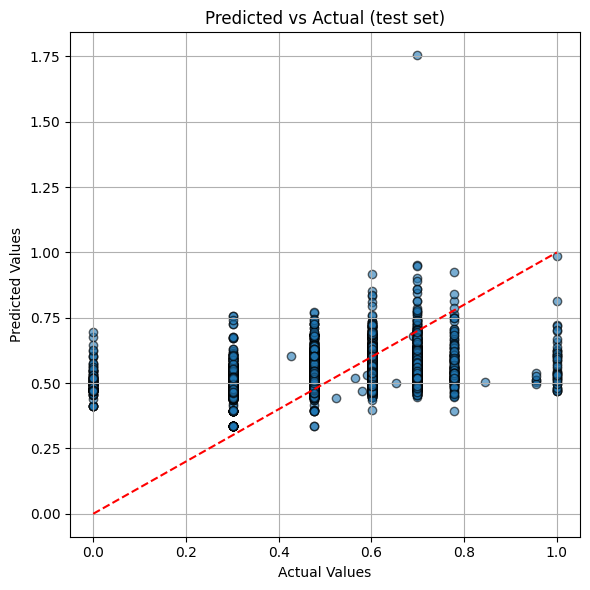

In [22]:
_ = model_data_judged(GNNRegression, "data_minmax_reg", "GNN_GCN_checkpoint_data_minmax_reg")

MAE:   0.1195
MSE:   0.0242
RMSE:  0.1555
R²:    -0.0040
MAPE:  23.65%
MPE:   -8.14%


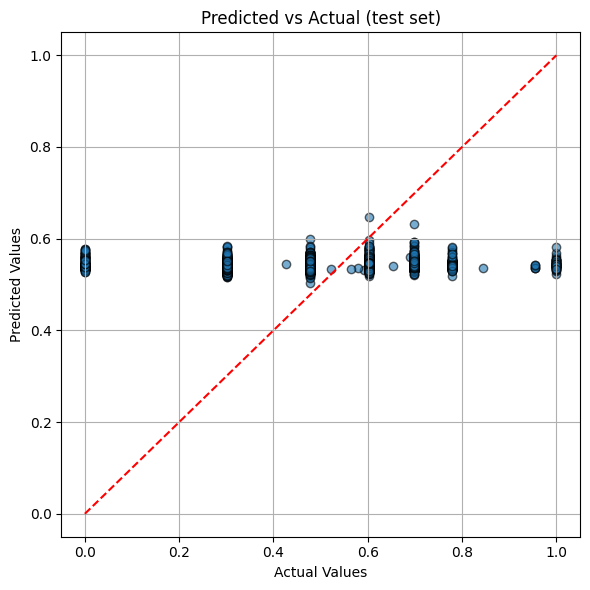

In [23]:
_ = model_data_judged(GraphSAGE_Regression, "data_minmax_reg", "GNN_Sage_checkpoint_data_minmax_reg")

***

## Classification

In [9]:
from utils.evaluate_gnn_model import evaluate_gnn_model
from utils.GNN_model import GNN, GraphSAGE_Classification

def model_data_judged(model_type, data, check):
    data_classification = torch.load(f"data/{data}.pt", weights_only=False)
    model = model_type(list(data_classification.x[0].shape)[0], 64, len(data_classification.y.unique()))

    train_mask_classification, val_mask_rclassification, test_mask_classification = create_split_masks(data_classification)
    data_classification.test_mask = test_mask_classification

    model_classification = model
    model_classification.load_state_dict(torch.load(f'check/{check}.pt', map_location='cpu'))  # or 'cuda'
    model_classification.eval()  
    result_GNN = evaluate_gnn_model(data_classification, model_classification, mask_type='test')

    return result_GNN

In [14]:
_ = model_data_judged(GNN, "data_minmax_catagg", "GNN_GCN_checkpoint_data_minmax_catagg")

Accuracy: 0.5063719272815124
Classification Report:
               precision    recall  f1-score   support

           0     0.6825    0.7018    0.6920      8505
           1     0.6119    0.2922    0.3955      7896
           2     0.0267    0.6923    0.0515       156

    accuracy                         0.5064     16557
   macro avg     0.4404    0.5621    0.3797     16557
weighted avg     0.6427    0.5064    0.5446     16557

Confusion Matrix:
 [[5969 1442 1094]
 [2750 2307 2839]
 [  27   21  108]]


In [11]:
_ = model_data_judged(GraphSAGE_Classification, "data_minmax_catagg", "GNN_Sage_checkpoint_data_minmax_catagg")

Accuracy: 0.633206498761853
Classification Report:
               precision    recall  f1-score   support

           0     0.7078    0.8916    0.7892      8505
           1     0.7690    0.3507    0.4817      7896
           2     0.0588    0.8462    0.1100       156

    accuracy                         0.6332     16557
   macro avg     0.5119    0.6961    0.4603     16557
weighted avg     0.7309    0.6332    0.6361     16557

Confusion Matrix:
 [[7583  808  114]
 [3130 2769 1997]
 [   0   24  132]]


In [12]:
_ = model_data_judged(GraphSAGE_Classification, "data_robust_catagg", "GNN_Sage_checkpoint_data_robust_catagg")

Accuracy: 0.6343540496466751
Classification Report:
               precision    recall  f1-score   support

           0     0.7062    0.8928    0.7886      8505
           1     0.7715    0.3520    0.4834      7896
           2     0.0595    0.8397    0.1111       156

    accuracy                         0.6344     16557
   macro avg     0.5124    0.6948    0.4610     16557
weighted avg     0.7313    0.6344    0.6367     16557

Confusion Matrix:
 [[7593  798  114]
 [3159 2779 1958]
 [   0   25  131]]


In [13]:
_ = model_data_judged(GraphSAGE_Classification, "data_standard_catagg", "GNN_Sage_checkpoint_data_standard_catagg")

Accuracy: 0.6406353808057015
Classification Report:
               precision    recall  f1-score   support

           0     0.7042    0.8968    0.7889      8505
           1     0.7795    0.3609    0.4934      7896
           2     0.0628    0.8333    0.1167       156

    accuracy                         0.6406     16557
   macro avg     0.5155    0.6970    0.4664     16557
weighted avg     0.7341    0.6406    0.6417     16557

Confusion Matrix:
 [[7627  780   98]
 [3203 2850 1843]
 [   0   26  130]]
